# **5.Regression Models**

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [6]:
# Load the dataset
df = pd.read_csv('news_share_data.csv')

In [7]:
# Separate features and target variable
X = df.drop('shares', axis=1)
y = df['shares']

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [10]:
# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


# **MODELS**

In [12]:
# Regression models
models = {
    'Linear Regression': LinearRegression(),
    'Logistic Regression': LogisticRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Polynomial Regression': Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ]),
}

**Helper function to calculate prediction interval**

In [36]:
def get_interval_estimate(actual_values, predicted_values, pi=.95):
    '''
    Get the interval estimate for the regression model.

    INPUTS:
        - actual_values (y_train)
        - predicted_values (prediction from x_train)
        - Prediction interval threshold (default = .95)
    OUTPUT:
        - Interval estimate
    '''

    #get standard deviation of prediction on the train dataset
    sum_errs = np.sum((actual_values - predicted_values)**2)
    stdev = np.sqrt(sum_errs / (len(actual_values) - 1))

    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2) # If we need to calculate a 'Two-tail test' (i.e. We're concerned with values both greater and less than our mean) then we need to split the significance (i.e. our alpha value) because we're still using a calculation method for one-tail. The split in half symbolizes the significance level being appropriated to both tails. A 95% significance level has a 5% alpha; splitting the 5% alpha across both tails returns 2.5%. Taking 2.5% from 100% returns 97.5% as an input for the significance level.
    z_score = stats.norm.ppf(ppf_lookup) # This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% (pi%) of data points would be contained if our data is a normal distribution.
    interval = z_score * stdev

    return interval


def get_prediction_interval(prediction, actual_values, predicted_values, pi=.95):
    '''
    Get a prediction interval for the regression model.

    INPUTS:
        - Single prediction (test data),
        - y_train
        - prediction from x_train,
        - Prediction interval threshold (default = .95)
    OUTPUT:
        - Prediction interval for single test prediction
    '''

    #get standard deviation of prediction on the train dataset
    sum_errs = np.sum((actual_values - predicted_values)**2)
    stdev = np.sqrt(sum_errs / (len(actual_values) - 1))

    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2) # If we need to calculate a 'Two-tail test' (i.e. We're concerned with values both greater and less than our mean) then we need to split the significance (i.e. our alpha value) because we're still using a calculation method for one-tail. The split in half symbolizes the significance level being appropriated to both tails. A 95% significance level has a 5% alpha; splitting the 5% alpha across both tails returns 2.5%. Taking 2.5% from 100% returns 97.5% as an input for the significance level.
    z_score = stats.norm.ppf(ppf_lookup) # This will return a value (that functions as a 'standard-deviation multiplier') marking where 95% (pi%) of data points would be contained if our data is a normal distribution.
    interval = z_score * stdev


    #generate prediction interval lower and upper bound cs_24
    lower_vet, upper_vet = prediction - interval, prediction + interval
    return lower_vet[0], upper_vet[0]

**1. Linear Regression**

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a pipeline with preprocessor and Linear Regression
pipeline_linear = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('regressor', LinearRegression())])

# Fit the model
pipeline_linear.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['article_id', 'unique_tokens_rate', 'num_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_...te_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['title', 'text', 'published_date', 'data_channel'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [18]:
y_pred_linear = pipeline_linear.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_linear))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_linear))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_linear)))

MAE: 6914.417781894577
MSE: 2201521779.8241982
RMSE: 46920.37702133475


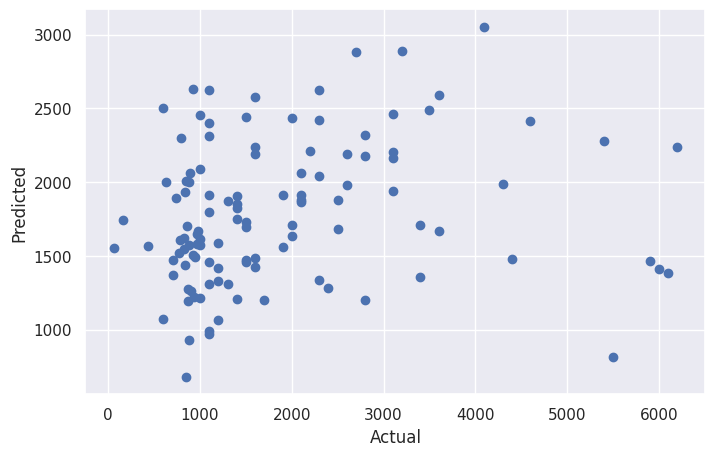

In [ ]:
# Plotting the predicted and actual data
plt.figure(figsize=(8,5))
plt.scatter(y_test,y_pred_linear)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

In [22]:
X_test[:10]

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity
626,7006962,Twitter Announces Pop-Up Notifications for Web,Twitter is bringing notification alerts to the...,2014-04-10,0.544276,9,2,0,4.868476,9,...,0.0000,3811.095,1938.888,603.0000,0.516804,0.077870,0.031315,0.018789,1.00,0.00
629,7026439,"When Trying to Help the Poor, One Word Can Mak...",A social experiment from the UK shows how a co...,2014-04-10,0.646789,15,9,0,4.770563,10,...,0.0000,8421.329,4019.202,13100.0000,0.497685,0.230370,0.069264,0.008658,0.20,0.20
847,2538239,NBA Star Damian Lillard Is So Awkward in New F...,"If you want to be a true sports star, then you...",2014-04-15,0.643312,3,1,0,4.443750,7,...,1017.5450,3791.311,2729.328,3100.0000,0.512626,0.067677,0.025000,0.018750,0.30,-0.15
514,7028583,Facebook Stock Up 5% as Sheryl Sandberg Vows N...,Facebook stock jumped 5% in early trading Wedn...,2014-04-09,0.573770,6,2,0,4.922680,9,...,851.2353,3574.499,2590.595,1500.0000,0.468687,0.104040,0.030928,0.015464,0.50,0.50
365,7009622,Google Bus Protests: How Far Is Too Far?,Had you been standing on the corner of 24th an...,2014-04-07,0.647458,5,0,3,4.838384,8,...,1616.9390,7270.152,3606.246,4666.6670,0.511288,-0.074700,0.030303,0.026936,0.80,0.40
903,7024024,KFC Doubles Down on the Double Down Sandwich,Fearless gastronomes take note: KFC's Double D...,2014-04-16,0.580645,10,1,0,4.972222,7,...,897.3333,3613.040,2332.949,0.0000,0.300000,0.227500,0.012346,0.003086,0.00,0.00
655,2947289,WikiLeaks Live Tweets Glenn Greenwald's Flight...,"Glenn Greenwald and Laura Poitras, two of the ...",2014-04-11,0.466176,10,1,0,4.732272,7,...,331.0000,3931.328,1940.874,0.0000,0.486761,0.168000,0.054993,0.017366,0.95,0.75
528,7008454,Officials: We'll Find Missing Plane in the 'No...,Underwater search teams in the Indian Ocean ha...,2014-04-09,0.537698,12,1,0,4.817121,10,...,0.0000,3574.499,2415.039,0.0000,0.475154,0.183098,0.060311,0.013619,0.50,0.50
321,7010766,'Game of Thrones' School Pictures Will Make Yo...,Life expectancy is tragically short on Game of...,2014-04-06,0.535144,11,1,1,4.824645,9,...,0.0000,3569.084,2193.075,982.6667,0.582952,0.230374,0.058452,0.012638,0.95,0.60
70,7033423,"3,800 Flights Canceled in Lufthansa Pilot Strike",Lufthansa airlines canceled 900 regional and d...,2014-04-02,0.503782,48,0,1,4.466855,7,...,3578.1630,9566.667,5995.717,14650.0000,0.545283,0.135756,0.038082,0.014104,0.00,0.00


In [23]:
y_pred_linear[:10]

array([ 4008.95906775,  8078.2794616 ,  3384.69058952,  2492.80413847,
        5311.69434005, -1679.20828174,  1120.99155891,  3013.84205499,
        5825.41184888,  8889.20770501])

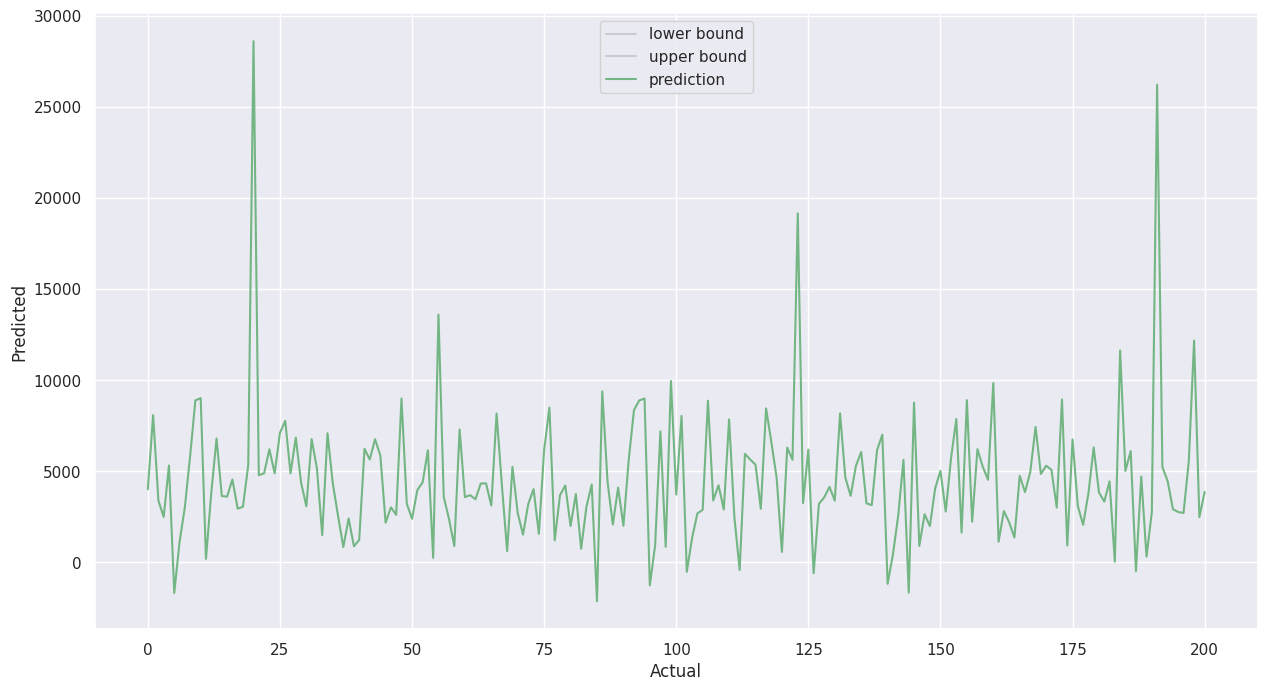

In [38]:
# Plotting the predicted and actual data
plt.figure(figsize=(15,8))
plt.plot(lower_vet,label='lower bound',alpha=0.3,color='grey')
plt.plot(upper_vet,label='upper bound',alpha=0.3,color='grey')
plt.plot(y_pred_linear,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

**2. Logistic Regression**

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

# Create a pipeline with preprocessor and Logistic Regression
pipeline_logistic = Pipeline(steps=[('preprocessor', preprocessor),
                                     ('regressor', LogisticRegression())])

# Fit the model
pipeline_logistic.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['article_id', 'unique_tokens_rate', 'num_hrefs', 'num_imgs',
       'num_videos', 'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_..._positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['title', 'text', 'published_date', 'data_channel'], dtype='object'))])),
                ('regressor', LogisticRegression())])

In [28]:
y_pred_logistic = pipeline_logistic.predict(X_test)
mse_logistic = mean_squared_error(y_test, y_pred_logistic)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_logistic))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_logistic))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_logistic)))

MAE: 5934.1592039801
MSE: 2230744267.064677
RMSE: 47230.755520790444


In [29]:
y_pred_logistic[:10]

array([1100, 3100,  827, 1900, 1600, 1100, 3400, 1900, 2300, 2900])

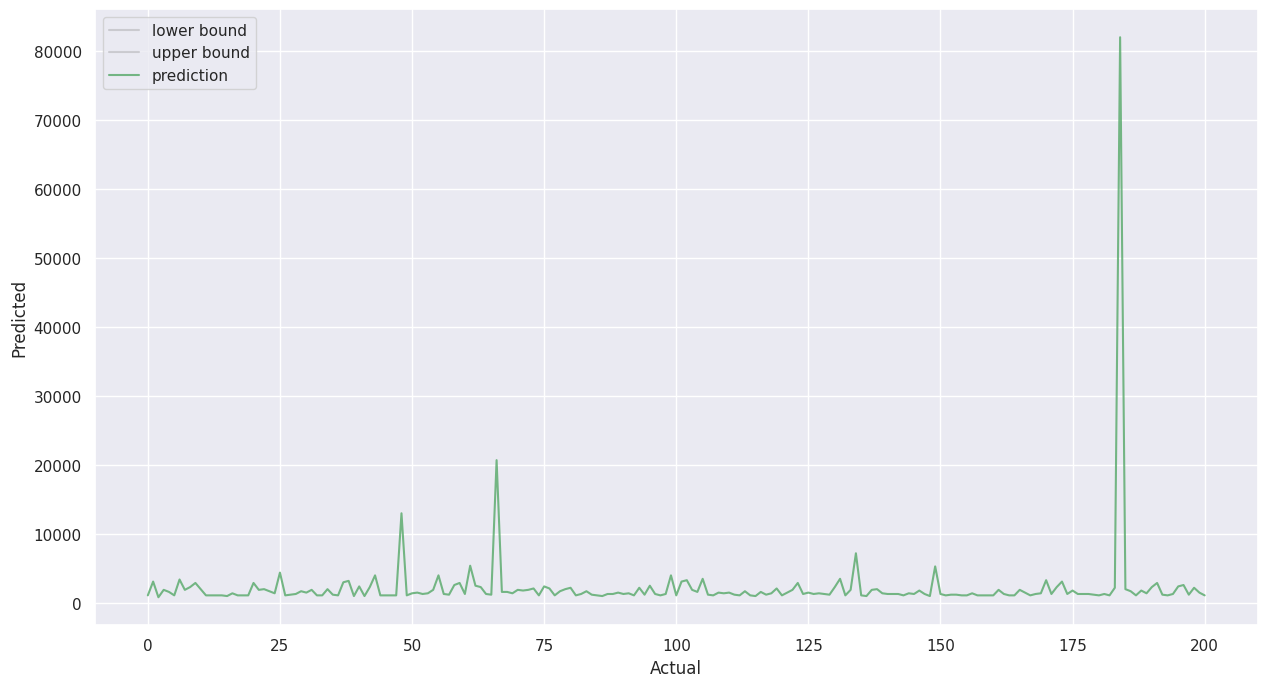

In [30]:
# Plotting the predicted and actual data
plt.figure(figsize=(15,8))
plt.plot(lower_vet,label='lower bound',alpha=0.3,color='grey')
plt.plot(upper_vet,label='upper bound',alpha=0.3,color='grey')
plt.plot(y_pred_logistic,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

**3. Ridge Regression**

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Create a pipeline with preprocessor and Ridge Regression
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', Ridge())])

# Fit the model
pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['article_id', 'unique_tokens_rate', 'hrefs', 'images', 'videos',
       'average_token_length', 'keywords', 'avg_avg_key',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rat...
       'title_subjectivity', 'day_of_week', 'is_weekend', 'title_word_count',
       'text_word_count', 'title_avg_word_length', 'text_avg_word_length'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['title', 'text', 'data_channel', 'title_sentiment', 'text_sentiment'], dtype='object'))])),
                ('regressor', Ridge())])

In [ ]:
y_pred_ridge = pipeline_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_ridge))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_ridge))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_ridge)))

MAE: 913.5119589946951
MSE: 1788253.1442492236
RMSE: 1337.2558260292694


In [ ]:
y_pred_ridge[:10]

array([1878.53664967, 1802.39548388, 1310.75129865, 2421.71500593,
       1483.51778507, 2064.27946171, 3053.66204609,  936.72730021,
       1619.22332972,  823.43720952])

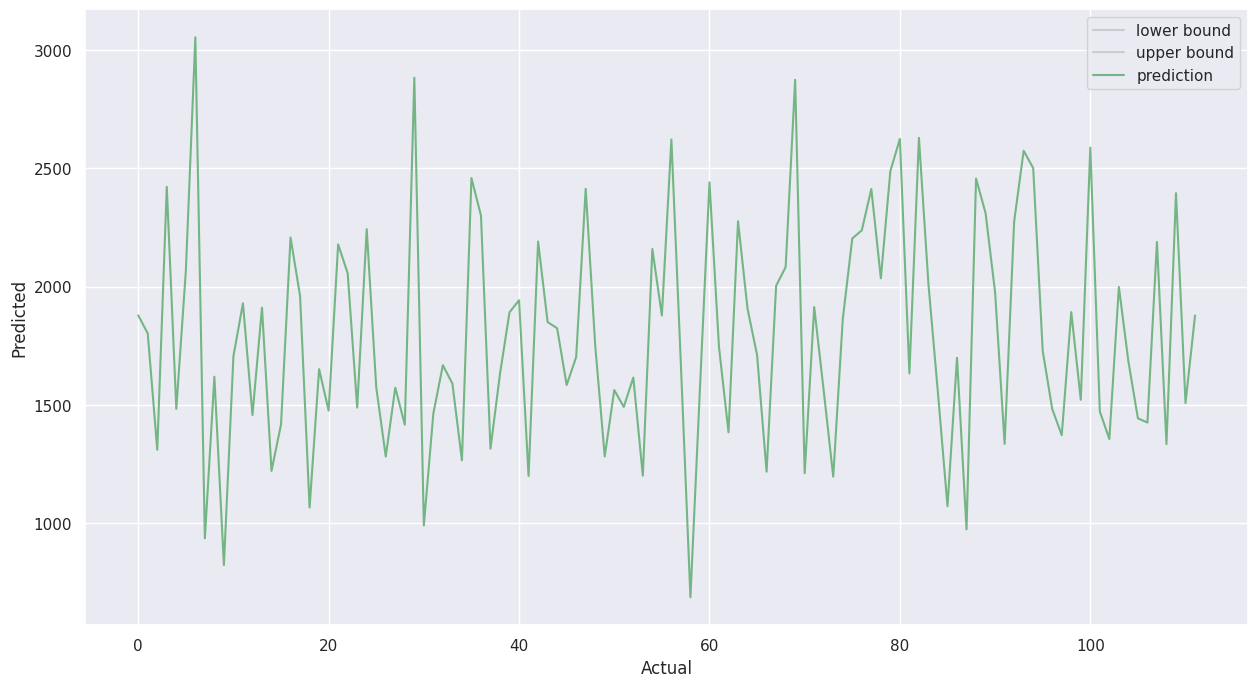

In [ ]:
# Plotting the predicted and actual data
plt.figure(figsize=(15,8))
plt.plot(lower_vet,label='lower bound',alpha=0.3,color='grey')
plt.plot(upper_vet,label='upper bound',alpha=0.3,color='grey')
plt.plot(y_pred_ridge,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

**4. Lasso Regression**

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Create a pipeline with preprocessor and Lasso Regression
pipeline_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', Lasso())])

# Fit the model
pipeline_lasso.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['article_id', 'unique_tokens_rate', 'hrefs', 'images', 'videos',
       'average_token_length', 'keywords', 'avg_avg_key',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rat...
       'title_subjectivity', 'day_of_week', 'is_weekend', 'title_word_count',
       'text_word_count', 'title_avg_word_length', 'text_avg_word_length'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['title', 'text', 'data_channel', 'title_sentiment', 'text_sentiment'], dtype='object'))])),
                ('regressor', Lasso())])

In [ ]:
# Evaluate the model
y_pred_lasso = pipeline_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lasso))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_lasso))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lasso)))

MAE: 883.8790242615186
MSE: 1854735.0204063957
RMSE: 1361.8865666443721


In [ ]:
y_pred_lasso[:10]

array([1525.5767828 , 1693.97629889, 1245.81985478, 1762.00824992,
       1304.10195146, 1644.7261071 , 2735.60137941,  978.97698913,
       1360.85696531,  737.3165531 ])

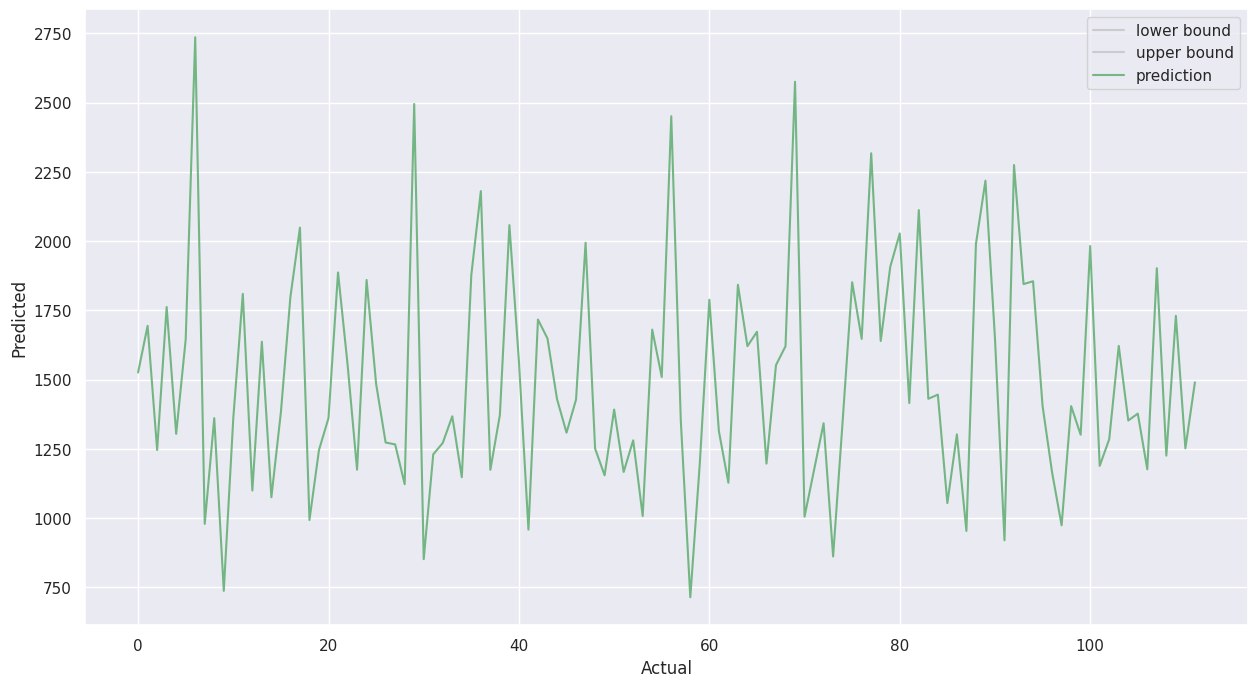

In [ ]:
# Plotting the predicted and actual data
plt.figure(figsize=(15,8))
plt.plot(lower_vet,label='lower bound',alpha=0.3,color='grey')
plt.plot(upper_vet,label='upper bound',alpha=0.3,color='grey')
plt.plot(y_pred_lasso,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

**5. Polynomial Regression**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create a pipeline with preprocessor and Polynomial Regression
pipeline_poly = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('poly', PolynomialFeatures(degree=2)),
                                 ('regressor', LinearRegression())])

# Fit the model
pipeline_poly.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['article_id', 'unique_tokens_rate', 'hrefs', 'images', 'videos',
       'average_token_length', 'keywords', 'avg_avg_key',
       'global_subjectivity', 'global_sentiment_polarity',
       'global_rate_positive_words', 'global_rat...
       'text_word_count', 'title_avg_word_length', 'text_avg_word_length'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['title', 'text', 'data_channel', 'title_sentiment', 'text_sentiment'], dtype='object'))])),
                ('poly', PolynomialFeatures()),
                ('regressor', LinearRegression())])

In [ ]:
# Evaluate the model
y_pred_poly = pipeline_poly.predict(X_test)
mse_poly = mean_squared_error(y_test, y_pred_poly)
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_poly))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_poly))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_poly)))

MAE: 1118.9112191685547
MSE: 2356515.9275667146
RMSE: 1535.0947617546985


In [ ]:
y_pred_poly[:10]

array([1703.95431941, 2923.65157573, 1296.40306183, 3337.17818786,
        900.86730463, 3190.74017728, 4168.92211689,  357.70867539,
       1587.81324448, 2490.57690154])

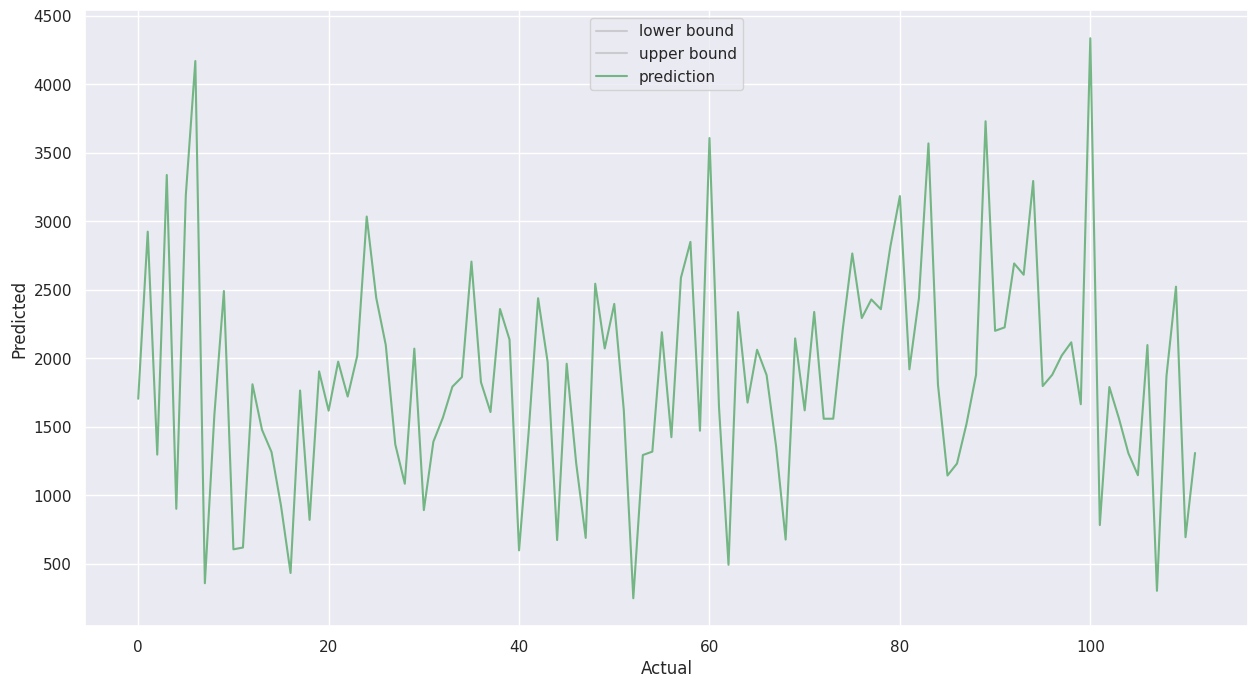

In [ ]:
# Plotting the predicted and actual data
plt.figure(figsize=(15,8))
plt.plot(lower_vet,label='lower bound',alpha=0.3,color='grey')
plt.plot(upper_vet,label='upper bound',alpha=0.3,color='grey')
plt.plot(y_pred_poly,label='prediction',alpha=0.8,color='g')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.show()

# **6. Finding best model**

In [ ]:
# Display Mean Squared Error for each model
models_mse = {
    'Linear Regression': mse_linear,
    'Logistic Regression': mse_logistic,
    'Ridge Regression': mse_ridge,
    'Lasso Regression': mse_lasso,
    'Polynomial Regression': mse_poly,
}

best_model_name = min(models_mse, key=models_mse.get)
best_model_mse = models_mse[best_model_name]

print(f'Best Model: {best_model_name}')
print(f'Mean Squared Error: {best_model_mse}')

Best Model: Ridge Regression
Mean Squared Error: 1788253.1442492236


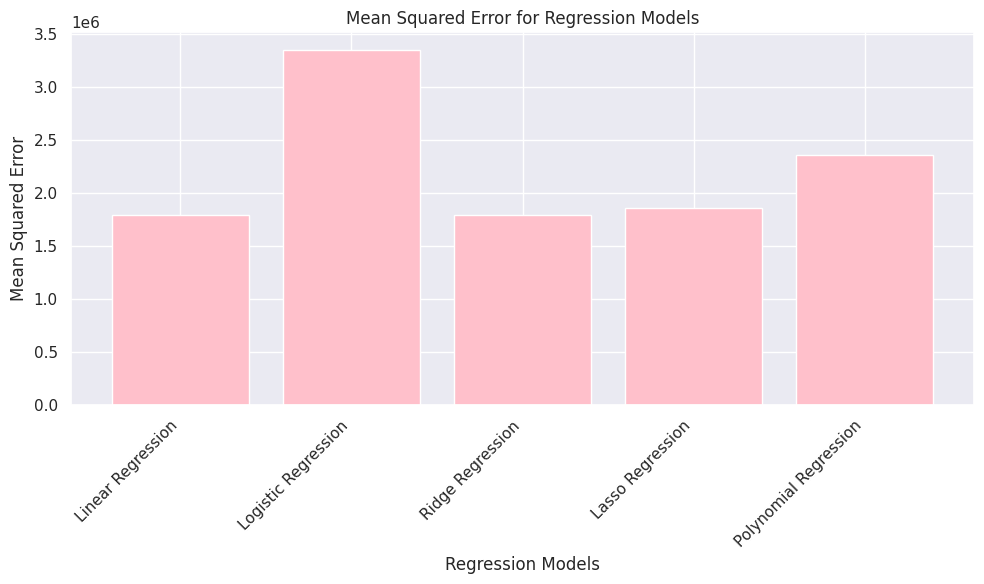

In [ ]:
import matplotlib.pyplot as plt

# Mean Squared Error values for each model
mse_values = list(models_mse.values())

# Model names
model_names = list(models_mse.keys())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values, color='pink')
plt.title('Mean Squared Error for Regression Models')
plt.xlabel('Regression Models')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()